In [1]:
import pandas as pd
import urllib.request
import json
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable
import time
import numpy as np  
import folium


In [2]:
url = 'https://dadosabertos.aneel.gov.br/dataset/f9336ee6-7562-4c92-880a-d7217df6cc94/resource/28686698-544b-48e2-af58-ad4f7616246c/download/projetos-eficiencia-energetica-empresa.csv'
df = pd.read_csv(url, encoding='ISO-8859-1', sep=';', on_bad_lines='skip', header=0)

In [3]:
df['DatGeracaoConjuntoDados'] = pd.to_datetime(df['DatGeracaoConjuntoDados'])
df['DatInicioProjeto'] = pd.to_datetime(df['DatInicioProjeto'])
df['DatConclusaoProjeto'] = pd.to_datetime(df['DatConclusaoProjeto'])

In [4]:
df['VlrCustoTotal'] = pd.to_numeric(df['VlrCustoTotal'].str.replace(',', '.'), errors='coerce')
df['VlrRcbGlobal'] = pd.to_numeric(df['VlrRcbGlobal'].str.replace(',', '.'), errors='coerce')
df['VlrEnergiaEconomizadaTotal'] = pd.to_numeric(df['VlrEnergiaEconomizadaTotal'].str.replace(',', '.'), errors='coerce')
df['VlrRetiradaDemandaPontaTotal'] = pd.to_numeric(df['VlrRetiradaDemandaPontaTotal'].str.replace(',', '.'), errors='coerce')

In [5]:
df['VlrCustoTotal'] = pd.to_numeric(df['VlrCustoTotal'], errors='coerce')
df['VlrRcbGlobal'] = pd.to_numeric(df['VlrRcbGlobal'], errors='coerce')
df['VlrEnergiaEconomizadaTotal'] = pd.to_numeric(df['VlrEnergiaEconomizadaTotal'], errors='coerce')
df['VlrRetiradaDemandaPontaTotal'] = pd.to_numeric(df['VlrRetiradaDemandaPontaTotal'], errors='coerce')

In [6]:
# Instanciando o geocodificador com um timeout maior
geolocator = Nominatim(user_agent="geoapiExercises", timeout=10)

# Função para obter endereço e coordenadas com retry
def get_location(name, cache):
    retries = 3
    for _ in range(retries):
        if name in cache:
            return cache[name]
        try:
            location = geolocator.geocode(name)
            if location:
                result = (location.address, location.latitude, location.longitude)
            else:
                result = (None, None, None)
            cache[name] = result
            return result
        except (GeocoderTimedOut, GeocoderUnavailable) as e:
            print(f"Retry for {name} due to error: {str(e)}")
            time.sleep(5)  # Espera antes de tentar novamente
    return None, None, None

# Função para processar os nomes únicos e preencher as informações de localização
def process_names(names, delay=1):
    location_cache = {}
    results = {'address': [], 'latitude': [], 'longitude': []}
    for name in names:
        address, lat, lon = get_location(name, location_cache)
        results['address'].append(address)
        results['latitude'].append(lat)
        results['longitude'].append(lon)
        time.sleep(delay)  # Delay para respeitar os limites da API
    return results, location_cache

# Extrair nomes únicos de agentes
nomes_unicos = df['NomAgente'].unique()

# Processar os nomes para obter as informações de localização
location_results, cache = process_names(nomes_unicos)

# Adicionando os resultados ao DataFrame
df['Address'] = df['NomAgente'].map({name: addr for name, (addr, _, _) in cache.items()})
df['Latitude'] = df['NomAgente'].map({name: lat for name, (_, lat, _) in cache.items()})
df['Longitude'] = df['NomAgente'].map({name: lon for name, (_, _, lon) in cache.items()})

Retry for COMPANHIA ENERGÉTICA DO RIO GRANDE DO NORTE COSERN due to error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=COMPANHIA+ENERG%C3%89TICA+DO+RIO+GRANDE+DO+NORTE+COSERN&format=json&limit=1 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x00000241F6C29310>, 'Connection to nominatim.openstreetmap.org timed out. (connect timeout=10)'))
Retry for COMPANHIA ENERGÉTICA DO RIO GRANDE DO NORTE COSERN due to error: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=COMPANHIA+ENERG%C3%89TICA+DO+RIO+GRANDE+DO+NORTE+COSERN&format=json&limit=1 (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x00000241F6C25B10>, 'Connection to nominatim.openstreetmap.org timed out. (connect timeout=10)'))
Retry for COMPANHIA ENERGÉTICA DO RIO GRANDE DO NORTE COSERN due to error: HTTPSConnectionPool(host='nominatim.openstreetmap.org',

In [7]:
df[df['Address'].notnull()][['Address', 'NomAgente', 'Latitude', 'Longitude']].head(10)

,Address,NomAgente,Latitude,Longitude
20,"Copel Distribuição S.A., Rua Vicente Machado, ...",COPEL DISTRIBUICAO S.A.,-25.386962,-51.474271
21,"Copel Distribuição S.A., Rua Vicente Machado, ...",COPEL DISTRIBUICAO S.A.,-25.386962,-51.474271
38,"Companhia Paulista de Força e Luz, Avenida Set...",COMPANHIA PAULISTA DE FORÇA E LUZ,-20.535621,-49.324210
41,"Companhia Paulista de Força e Luz, Avenida Set...",COMPANHIA PAULISTA DE FORÇA E LUZ,-20.535621,-49.324210
43,"Copel Distribuição S.A., Rua Vicente Machado, ...",COPEL DISTRIBUICAO S.A.,-25.386962,-51.474271
44,"Copel Distribuição S.A., Rua Vicente Machado, ...",COPEL DISTRIBUICAO S.A.,-25.386962,-51.474271
45,"Copel Distribuição S.A., Rua Vicente Machado, ...",COPEL DISTRIBUICAO S.A.,-25.386962,-51.474271
46,"Copel Distribuição S.A., Rua Vicente Machado, ...",COPEL DISTRIBUICAO S.A.,-25.386962,-51.474271
47,"Copel Distribuição S.A., Rua Vicente Machado, ...",COPEL DISTRIBUICAO S.A.,-25.386962,-51.474271
48,"Copel Distribuição S.A., Rua Vicente Machado, ...",COPEL DISTRIBUICAO S.A.,-25.386962,-51.474271


In [8]:
count = df[df['Address'].notnull()][['Address', 'NomAgente', 'Latitude', 'Longitude']].shape[0]
print(count)

2448


In [9]:
df[df['Address'].notnull()][['Address', 'NomAgente', 'Latitude', 'Longitude']].head(10)

,Address,NomAgente,Latitude,Longitude
20,"Copel Distribuição S.A., Rua Vicente Machado, ...",COPEL DISTRIBUICAO S.A.,-25.386962,-51.474271
21,"Copel Distribuição S.A., Rua Vicente Machado, ...",COPEL DISTRIBUICAO S.A.,-25.386962,-51.474271
38,"Companhia Paulista de Força e Luz, Avenida Set...",COMPANHIA PAULISTA DE FORÇA E LUZ,-20.535621,-49.324210
41,"Companhia Paulista de Força e Luz, Avenida Set...",COMPANHIA PAULISTA DE FORÇA E LUZ,-20.535621,-49.324210
43,"Copel Distribuição S.A., Rua Vicente Machado, ...",COPEL DISTRIBUICAO S.A.,-25.386962,-51.474271
44,"Copel Distribuição S.A., Rua Vicente Machado, ...",COPEL DISTRIBUICAO S.A.,-25.386962,-51.474271
45,"Copel Distribuição S.A., Rua Vicente Machado, ...",COPEL DISTRIBUICAO S.A.,-25.386962,-51.474271
46,"Copel Distribuição S.A., Rua Vicente Machado, ...",COPEL DISTRIBUICAO S.A.,-25.386962,-51.474271
47,"Copel Distribuição S.A., Rua Vicente Machado, ...",COPEL DISTRIBUICAO S.A.,-25.386962,-51.474271
48,"Copel Distribuição S.A., Rua Vicente Machado, ...",COPEL DISTRIBUICAO S.A.,-25.386962,-51.474271


In [10]:
df['NomAgente'].isnull().sum()

0

In [11]:
df_not_null = df[df['Address'].notnull()][['Address', 'NomAgente', 'Latitude', 'Longitude']]
df_not_null = df_not_null.drop_duplicates()

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7399 entries, 0 to 7398
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   DatGeracaoConjuntoDados       7399 non-null   datetime64[ns]
 1   NomAgente                     7399 non-null   object        
 2   IdeEmpresaProponenteProjeto   7399 non-null   int64         
 3   DscCodProjeto                 7399 non-null   object        
 4   DscTituloProjeto              7399 non-null   object        
 5   DscTipologia                  7399 non-null   object        
 6   VlrCustoTotal                 5229 non-null   float64       
 7   VlrRcbGlobal                  5789 non-null   float64       
 8   VlrEnergiaEconomizadaTotal    6463 non-null   float64       
 9   VlrRetiradaDemandaPontaTotal  6452 non-null   float64       
 10  DscObjetivo                   4186 non-null   object        
 11  DscJustificativa              

In [13]:
df_not_null.info()

<class 'pandas.core.frame.DataFrame'>
Index: 122 entries, 20 to 7251
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Address    122 non-null    object 
 1   NomAgente  122 non-null    object 
 2   Latitude   122 non-null    float64
 3   Longitude  122 non-null    float64
dtypes: float64(2), object(2)
memory usage: 4.8+ KB


In [14]:
# Passo 1: Identificar linhas com valores faltantes
mask = df[['Address', 'Latitude', 'Longitude']].isna().any(axis=1)

# Passo 2: Criar dicionário para mapeamento a partir de df_not_null
df_not_null_dict = df_not_null.set_index('NomAgente')[['Address', 'Latitude', 'Longitude']].to_dict('index')

# Função para preencher os valores faltantes
def fill_missing_values(row):
    if pd.isna(row['Address']) or pd.isna(row['Latitude']) or pd.isna(row['Longitude']):
        agent = row['NomAgente']
        if agent in df_not_null_dict:
            row['Address'], row['Latitude'], row['Longitude'] = df_not_null_dict[agent]['Address'], df_not_null_dict[agent]['Latitude'], df_not_null_dict[agent]['Longitude']
    return row

# Aplicar a função para preencher valores faltantes
df.loc[mask] = df.loc[mask].apply(fill_missing_values, axis=1)

# Passo 3: Verificação dos resultados
print(df[['Address', 'Latitude', 'Longitude']].isna().sum())


Address      4951
Latitude     4951
Longitude    4951
dtype: int64


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7399 entries, 0 to 7398
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   DatGeracaoConjuntoDados       7399 non-null   datetime64[ns]
 1   NomAgente                     7399 non-null   object        
 2   IdeEmpresaProponenteProjeto   7399 non-null   int64         
 3   DscCodProjeto                 7399 non-null   object        
 4   DscTituloProjeto              7399 non-null   object        
 5   DscTipologia                  7399 non-null   object        
 6   VlrCustoTotal                 5229 non-null   float64       
 7   VlrRcbGlobal                  5789 non-null   float64       
 8   VlrEnergiaEconomizadaTotal    6463 non-null   float64       
 9   VlrRetiradaDemandaPontaTotal  6452 non-null   float64       
 10  DscObjetivo                   4186 non-null   object        
 11  DscJustificativa              

In [16]:
# Set 'NomAgente' as the index
df.set_index('NomAgente', inplace=True)

In [17]:
# Exclude datetime columns and specific numeric columns
numeric_columns = df.select_dtypes(include=[np.number]).columns
numeric_columns = numeric_columns.drop(['IdeEmpresaProponenteProjeto', 'Latitude', 'Longitude'])

# Generate descriptive statistics for the numeric columns
desc_stats = df[numeric_columns].describe()


In [18]:
# Round the values in desc_stats to 2 decimal places
desc_stats_rounded = desc_stats.round(2)

# Set the float_format option in pandas
pd.options.display.float_format = '{:.2f}'.format

# Display the DataFrame
desc_stats_rounded

,VlrCustoTotal,VlrRcbGlobal,VlrEnergiaEconomizadaTotal,VlrRetiradaDemandaPontaTotal
count,5229.00,5789.00,6463.00,6452.00
mean,1172315.63,0.75,2450.97,1074.13
std,4384020.99,9.78,16218.47,38096.93
min,0.00,0.00,0.00,-0.67
25%,69746.00,0.35,116.06,21.33
50%,285082.58,0.55,338.17,72.25
75%,855654.90,0.70,1248.44,292.19
max,186249979.64,720.00,661617.46,3050000.00


In [19]:
# Define a small epsilon value to prevent division by zero
epsilon = 0.01

# Recalculate the score with epsilon added to the denominator to avoid division by zero
df['Score'] = (df['VlrEnergiaEconomizadaTotal'] + df['VlrRetiradaDemandaPontaTotal']) / (df['VlrCustoTotal'] + epsilon)

# Aggregate the scores again by the index, which represents NomAgente
aggregated_scores = df.groupby(df.index).agg(
    VlrEnergiaEconomizadaTotal=('VlrEnergiaEconomizadaTotal', 'sum'),
    VlrRetiradaDemandaPontaTotal=('VlrRetiradaDemandaPontaTotal', 'sum'),
    VlrCustoTotal=('VlrCustoTotal', 'mean'),  # Continue using mean or consider sum if more appropriate
    Score=('Score', 'mean')
).sort_values(by='Score', ascending=False)  # Sort to get the top-ranked agents

# Display the top rows of the aggregated and ranked DataFrame
aggregated_scores.head()


,VlrEnergiaEconomizadaTotal,VlrRetiradaDemandaPontaTotal,VlrCustoTotal,Score
NomAgente,,,,
Celesc Distribuição S/A,17032.79,3894.06,0.00,697561.67
COMPANHIA ENERGETICA DO PIAUÍ,2704.07,1128.46,0.00,383253.00
Rio Grande Energia S/A,8030.90,1542.65,0.00,277951.50
COMPANHIA ENERGETICA DE ALAGOAS,13556.78,4064.73,5303958.18,225893.80
Enel Distribuicao Sao Paulo,217579.91,33046.10,4544203.94,203848.09


In [20]:
aggregated_scores.index = aggregated_scores.index.str.capitalize()

In [21]:
aggregated_scores

,VlrEnergiaEconomizadaTotal,VlrRetiradaDemandaPontaTotal,VlrCustoTotal,Score
NomAgente,,,,
Celesc distribuição s/a,17032.79,3894.06,0.00,697561.67
Companhia energetica do piauí,2704.07,1128.46,0.00,383253.00
Rio grande energia s/a,8030.90,1542.65,0.00,277951.50
Companhia energetica de alagoas,13556.78,4064.73,5303958.18,225893.80
Enel distribuicao sao paulo,217579.91,33046.10,4544203.94,203848.09
...,...,...,...,...
S.a de eletrificacao da paraiba,6981.32,2332.94,NaN,NaN
Sulgipe,3208.20,1231.85,NaN,NaN
Uhenpal,157.27,22.62,NaN,NaN


In [22]:
aggregated_scores.info()

<class 'pandas.core.frame.DataFrame'>
Index: 537 entries, Celesc distribuição s/a to Usina hidro eletrica nova palma ltda.
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   VlrEnergiaEconomizadaTotal    537 non-null    float64
 1   VlrRetiradaDemandaPontaTotal  537 non-null    float64
 2   VlrCustoTotal                 288 non-null    float64
 3   Score                         288 non-null    float64
dtypes: float64(4)
memory usage: 21.0+ KB


In [23]:
df = df.reset_index()

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7399 entries, 0 to 7398
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   NomAgente                     7399 non-null   object        
 1   DatGeracaoConjuntoDados       7399 non-null   datetime64[ns]
 2   IdeEmpresaProponenteProjeto   7399 non-null   int64         
 3   DscCodProjeto                 7399 non-null   object        
 4   DscTituloProjeto              7399 non-null   object        
 5   DscTipologia                  7399 non-null   object        
 6   VlrCustoTotal                 5229 non-null   float64       
 7   VlrRcbGlobal                  5789 non-null   float64       
 8   VlrEnergiaEconomizadaTotal    6463 non-null   float64       
 9   VlrRetiradaDemandaPontaTotal  6452 non-null   float64       
 10  DscObjetivo                   4186 non-null   object        
 11  DscJustificativa              

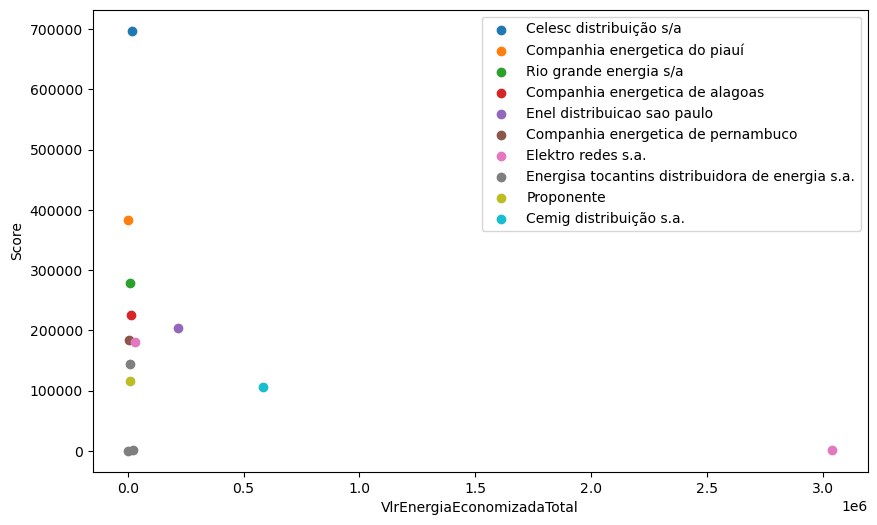

In [25]:
import matplotlib.pyplot as plt

# Sort by 'Score' and select the top 10 'NomAgente'
top_agents = aggregated_scores.sort_values(by='Score', ascending=False).head(10).index

plt.figure(figsize=(10, 6))
for agent in top_agents:
    agent_data = aggregated_scores.loc[agent]
    plt.scatter(agent_data['VlrEnergiaEconomizadaTotal'], agent_data['Score'], label=agent)

plt.xlabel('VlrEnergiaEconomizadaTotal')
plt.ylabel('Score')
plt.legend()
plt.show()

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7399 entries, 0 to 7398
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   NomAgente                     7399 non-null   object        
 1   DatGeracaoConjuntoDados       7399 non-null   datetime64[ns]
 2   IdeEmpresaProponenteProjeto   7399 non-null   int64         
 3   DscCodProjeto                 7399 non-null   object        
 4   DscTituloProjeto              7399 non-null   object        
 5   DscTipologia                  7399 non-null   object        
 6   VlrCustoTotal                 5229 non-null   float64       
 7   VlrRcbGlobal                  5789 non-null   float64       
 8   VlrEnergiaEconomizadaTotal    6463 non-null   float64       
 9   VlrRetiradaDemandaPontaTotal  6452 non-null   float64       
 10  DscObjetivo                   4186 non-null   object        
 11  DscJustificativa              

In [27]:
aggregated_scores.to_csv('aggregated_scores.csv')

In [28]:
df.to_csv('projetos-eficiencia-energetica-empresa-geocoded.csv', index=False)